In [12]:
import torch
import json
import os
import config
import matplotlib.patches as patches
import torchvision.transforms as T
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from datetime import datetime
from torch.utils.data import DataLoader
from data import YoloPascalVocDataset
from loss import SumSquaredErrorLoss
from models import *
import utils
import metrics
import plot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = 'models/ellipse_net/05_08_2024/11_53_33'

## Load the augmented data as an example(the model is trained using python3 train.py)

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


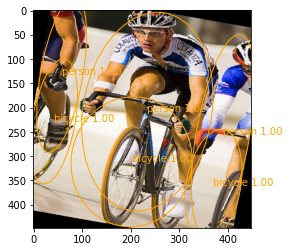

In [10]:
import metrics
from importlib import reload
import data
reload(metrics)
reload(utils)
reload(data)
# Data Augmentation and Generated Ground Truth Data (Originral Image with Box and Rotated Data with Box )
train_set = data.YoloPascalVocDataset('train', normalize=True, augment=False, duplicates=1) # No duplicates for now
loader = DataLoader(train_set, batch_size=1, shuffle=False)
for i, (image, labels, original) in enumerate(loader):
    if i==25:
        break
# label = labels[0]
# image, labels, original = next(iter(loader))
image = image.to(device) #plot ellipses doesnt work with cuda
labels = labels.to(device)
original = original.to(device)
image, labels, original = utils.prep_data(image, labels, original)
classes = utils.load_class_array()

# Plot rotated ground truth data with rotated ellipses
metrics.plot_ellipses(original[0], labels[0], classes, plot=True)

## Network (Provide an example image)

#### Network is trained in train.py and the checkpoints are saved in model_dir = models/ellipse_net/05_07_2024/12_30_16

Plot sample images from final model

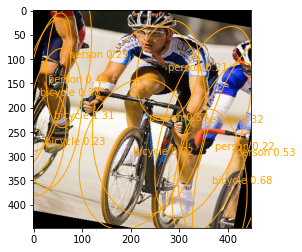

In [11]:
# Load the model
# plot.plot_test_ellipse(model_dir=model_dir, print_metrics=False, max_images=1, plot=True)
model = YOLOv1ResNet()
model.eval()
model.to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', 'final')))
predictions = model.forward(image)
metrics.plot_ellipses(
    original[0],
    predictions[0],
    classes,
    file=None,
    min_confidence=0.2,
    max_overlap=0.4,
    plot=True
)
del model, image, labels, original, predictions

## IOU Function for Two Ellipses (Provide two example ellipses)
VIP: PLEASE NOTE THAT X,Y ORIGIN IS TOP LEFT IN THIS EXAMPLE, WITH Y_POSITIVE GOING DOWN

First Test


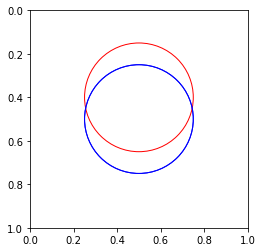

Bitmask IOU(used in ellipse-net) is: 0.5962474942207336
Circle Absolute Ground Truth IOU is: 0.5962457656860352
Second Test


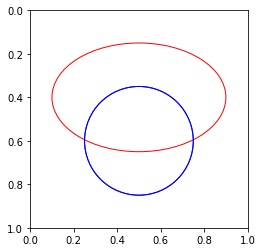

Bitmask IOU(used in ellipse-net) is: 0.28905972838401794


In [9]:
import math
# https://web.archive.org/web/20180422082904/http://mathforum.org/library/drmath/view/54785.html
def areaOfIntersection(x0, y0, r0, x1, y1, r1): # IOU of circles for comparison
    rr0 = r0*r0;
    rr1 = r1*r1;
    c = math.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0));
    phi = (math.acos((rr0+(c*c)-rr1) / (2*r0*c)))*2;
    theta = (math.acos((rr1+(c*c)-rr0) / (2*r1*c)))*2;
    area1 = 0.5*theta*rr1 - 0.5*rr1*math.sin(theta);
    area2 = 0.5*phi*rr0 - 0.5*rr0*math.sin(phi);
    return area1 + area2;

def iou_circle(x0,y0,r0,x1,y1,r1):
    intersection = areaOfIntersection(x0, y0, r0, x1, y1, r1);
    union = math.pi*r0*r0 + math.pi*r1*r1 - intersection;
    return (intersection/union).item();

# Feed an ellipse of equal major axis width and height(i.e. a circle to compare)
ell1 = torch.Tensor((0.5, 0.4, 0.5, 0.5, 1, 0.5)); # x, y, a, b, confidence, angle(ratio 0-1) of 180 degrees
ell2 = torch.Tensor((0.5, 0.5, 0.5, 0.5, 1, 0));
def report(ell1, ell2):
    # Plot the ellipses, x,y = 0,0 at the top left
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0) # this is reversed because the origin is at the top left
    ellipse = patches.Ellipse(ell1[:2], ell1[2], ell1[3], angle=ell1[5]*180, edgecolor='red', fill=False) # VIP 90-angle
    ax.add_patch(ellipse)

    ellipse = patches.Ellipse(ell2[:2], ell2[2], ell2[3], angle=ell2[5]*180, edgecolor='blue', fill=False) # VIP 90-angle
    ax.add_patch(ellipse)
    ax.add_patch(ellipse)
    # plt.savefig('iou_test.png')
    plt.show()
    plt.close()
    print("Bitmask IOU(used in ellipse-net) is:", utils.compute_iou_bitmask(ell1, ell2, 0.0001, 1, 1));

print("First Test");
report(ell1, ell2);
print("Circle Absolute Ground Truth IOU is:", iou_circle(ell1[0], ell1[1], ell1[2]/2, ell2[0], ell2[1], ell2[2]/2));
# Showcase another 2 ellipses not circles of given angle
print("Second Test");
ell1 = torch.Tensor((0.5, 0.4, 0.5, 0.8, 1, 0.5)); # x, y, a, b, confidence, angle(ratio 0-1) of 180 degrees
ell2 = torch.Tensor((0.5, 0.6, 0.5, 0.5, 1, 0));
report(ell1, ell2);

#### We see above that the circle absolute form IOU near perfectly matches our bitmasking technique, verifying full functionality. We also see the iou for a second example below one that involves ellipse rotation(90 degrees). PLEASE NOTE ANGLES ARE INPUTTED AS A RATIO OF 180 DEGREES OR PI

## MAP Function (Provide  two examples )

/home/nyuad/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


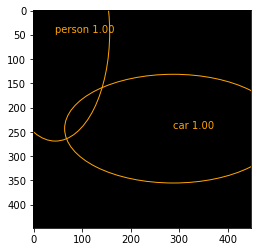

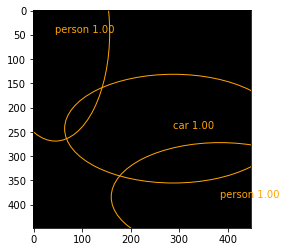

mAP: 0.7499986886978149


In [4]:
from importlib import reload
import metrics
reload(metrics)
reload(utils)
classes = utils.load_class_array()
# Generate mock ellipse
def generate_ellipse(x, y, a, b, confidence, angle):
    return torch.tensor([x, y, a, b, confidence, angle])

# Add ellipse to predictions
def add_ellipse(ellipse, predictions, class_index, grid_x=0, grid_y=0):
    predictions[0, grid_x, grid_y, config.C:(config.C + 6)] = ellipse # add ellipse
    predictions[0, grid_x, grid_y, class_index] = 1 # add one-hot encoded class label
    return predictions

prediction = torch.zeros(1, 7, 7, config.C + 6 * config.B)
add_ellipse(generate_ellipse(0.1, 0.1, 1, 0.5, 1, 0.5), prediction, 1, 0, 0)
add_ellipse(generate_ellipse(0.5, 0.4, 1, 0.5, 1, 0), prediction, 0, 1, 1)
blank_image = torch.zeros(1, 3, config.IMAGE_SIZE[0], config.IMAGE_SIZE[1])

# Plot the ellipses of the predictions
metrics.plot_ellipses(blank_image[0], prediction[0], classes, file=None, min_confidence=0.2, max_overlap=0.4, plot=True)

ground_truth = torch.zeros(1, 7, 7, config.C + 6 * config.B)
add_ellipse(generate_ellipse(0.1, 0.1, 1, 0.5, 1, 0.5), ground_truth, 1, 0, 0)
add_ellipse(generate_ellipse(0.5, 0.4, 1, 0.5, 1, 0), ground_truth, 0, 1, 1)
add_ellipse(generate_ellipse(0, 0, 1, 0.5, 1, 0), ground_truth, 1, 6, 6) # wrong 0.5 its doing nms
# Plot gt ellipses
metrics.plot_ellipses(blank_image[0], ground_truth[0], classes, file=None, min_confidence=0.2, max_overlap=1.0, plot=True)

# Get prediction Correct or not
predictions, total_gt = metrics.get_ellipse_predictions(ground_truth, prediction, conf_threshold=0.5, iou_threshold=0.1)
mAP = metrics.get_mAP(predictions, total_gt)
print('mAP:', mAP)

Since 2/3rds of the predictions are correct, an mAP of 0.75 is expected

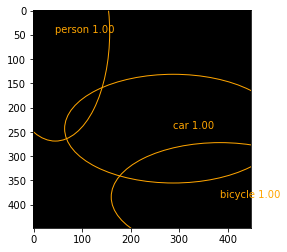

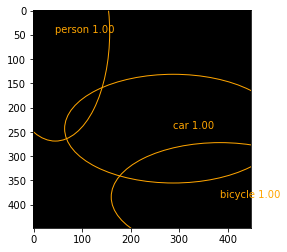

mAP: 0.9999980926513672


In [7]:
# Another mAP example
prediction = torch.zeros(1, 7, 7, config.C + 6 * config.B)
add_ellipse(generate_ellipse(0.1, 0.1, 1, 0.5, 1, 0.5), prediction, 1, 0, 0)
add_ellipse(generate_ellipse(0.5, 0.4, 1, 0.5, 1, 0), prediction, 0, 1, 1)
add_ellipse(generate_ellipse(0, 0, 1, 0.5, 1, 0), prediction, 3, 6, 6)

ground_truth = torch.zeros(1, 7, 7, config.C + 6 * config.B)
add_ellipse(generate_ellipse(0.1, 0.1, 1, 0.5, 1, 0.5), ground_truth, 1, 0, 0)
add_ellipse(generate_ellipse(0.5, 0.4, 1, 0.5, 1, 0), ground_truth, 0, 1, 1)
add_ellipse(generate_ellipse(0, 0, 1, 0.5, 1, 0), ground_truth, 3, 6, 6)

# Plot gt ellipses
metrics.plot_ellipses(blank_image[0], ground_truth[0], classes, file=None, min_confidence=0.2, max_overlap=1.0, plot=True)
metrics.plot_ellipses(blank_image[0], prediction[0], classes, file=None, min_confidence=0.2, max_overlap=1.0, plot=True)

# Get prediction Correct or not
predictions, total_gt = metrics.get_ellipse_predictions(ground_truth, prediction, conf_threshold=0.5, iou_threshold=0.1)
mAP = metrics.get_mAP(predictions, total_gt)
print('mAP:', mAP)

We get a full mAP of 100%, since all predictions are correct

### Loss function is in loss.py
## Training & Test Loss Curve & mAP curve

In [2]:
# Get mAP from each model learning checkpoint
model = YOLOv1ResNet()
model.eval()
model.to(device)

test_set = YoloPascalVocDataset('test', normalize=True, augment=False, duplicates=1, angle_range=30) # No duplicates for now, dont augment
train_set = YoloPascalVocDataset('train', normalize=True, augment=False, duplicates=1, angle_range=30) # No duplicates for now, dont augment
train_loader = DataLoader(
        train_set,
        batch_size=config.BATCH_SIZE,
        num_workers=8,
        persistent_workers=True,
        drop_last=True,
        shuffle=True
    )
test_loader = DataLoader(
    test_set,
    batch_size=config.BATCH_SIZE,
    num_workers=8,
    persistent_workers=True,
    drop_last=True
)
loss_fn = SumSquaredErrorLoss(step_size=10)

def gather_metrics(dataloader, model_dir=model_dir, map_name='mAP_array', loss_name='train_loss_array'):
    directories = os.listdir(os.path.join(model_dir, 'weights'))
    mAP_array = torch.zeros(2, len(directories)) # 1st row is the epoch, 2nd row is the mAP
    loss_array = torch.zeros(2, len(directories)) # 1st row is the epoch, 2nd row is the mAP
    # For each file in the model_dir/weights folder
    for index, file in enumerate(directories):
        with torch.no_grad():
            
            # Load the model
            model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', file)))
            all_ellipse_predictions = torch.zeros((len(dataloader)*config.S*config.S*config.B*config.BATCH_SIZE, 8))
            start_index = 0
            loss = 0;
            total_gt = torch.zeros(len(utils.load_class_array()), device=device)
            for image, labels, original in tqdm(dataloader):
                image = image.to(device)
                labels = labels.to(device)
                original = original.to(device)
                image, labels, original = utils.prep_data(image, labels, original);
                predictions = model.forward(image)
                loss += loss_fn(predictions, labels)
                # Get prediction Correct or not
                predictions, gt = metrics.get_ellipse_predictions(labels, predictions, conf_threshold=0.2, iou_threshold=0.4, step=8)
                total_gt += gt
                all_ellipse_predictions[start_index:(start_index+len(predictions))] = predictions
                start_index += len(predictions)
                torch.cuda.empty_cache()
                del image, labels, original, predictions
            
        # Compute mAP
        mAP = metrics.get_mAP(all_ellipse_predictions, total_gt)
        print(f'{file}: {mAP}')
        # If file is an int then set to epoch o.w set to config.EPOCHS
        epoch = int(file) if file.isdigit() else config.EPOCHS
        mAP_array[0, index] = epoch
        mAP_array[1, index] = mAP
        loss_array[0, index] = epoch
        loss_array[1, index] = loss

    # Save the mAP array
    mAP_array = mAP_array.cpu().numpy()
    torch.save(mAP_array, os.path.join(model_dir, map_name))   

    # Save the train loss array
    loss_array = loss_array.cpu().numpy()
    torch.save(loss_array, os.path.join(model_dir, loss_name))

gather_metrics(test_loader, model_dir=model_dir, map_name='test_mAP_array', loss_name='test_loss_array')
gather_metrics(train_loader, model_dir=model_dir, map_name='train_mAP_array', loss_name='train_loss_array')
del model, train_loader, test_loader, test_set, train_set

/home/nyuad/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


  0%|          | 0/78 [00:00<?, ?it/s]/home/nyuad/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 78/78 [07:34<00:00,  5.82s/it]


5: 0.052725423127412796


100%|██████████| 78/78 [07:30<00:00,  5.77s/it]


100: 0.17589744925498962


100%|██████████| 78/78 [07:30<00:00,  5.77s/it]


85: 0.16821753978729248


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


95: 0.16365304589271545


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


120: 0.16074731945991516


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


90: 0.16709642112255096


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


115: 0.15789225697517395


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


65: 0.16000984609127045


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


55: 0.16210702061653137


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


20: 0.11922062933444977


100%|██████████| 78/78 [07:33<00:00,  5.81s/it]


15: 0.11480478942394257


100%|██████████| 78/78 [07:29<00:00,  5.76s/it]


10: 0.08666288107633591


100%|██████████| 78/78 [07:32<00:00,  5.81s/it]


80: 0.15644825994968414


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


final: 0.17104680836200714


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


50: 0.14740978181362152


100%|██████████| 78/78 [07:26<00:00,  5.72s/it]


0: 0.1269201785326004


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]


75: 0.15820714831352234


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


60: 0.1576201617717743


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


70: 0.16537483036518097


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


130: 0.16148479282855988


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]


25: 0.14447467029094696


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


40: 0.15139156579971313


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


125: 0.1575811505317688


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


35: 0.15019947290420532


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


30: 0.1371648609638214


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


105: 0.16943998634815216


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


110: 0.16217003762722015


100%|██████████| 78/78 [07:29<00:00,  5.77s/it]


45: 0.15013910830020905


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


5: 0.06120646744966507


100%|██████████| 78/78 [07:29<00:00,  5.77s/it]


100: 0.22650139033794403


100%|██████████| 78/78 [07:29<00:00,  5.77s/it]


85: 0.21734102070331573


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


95: 0.22051291167736053


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


120: 0.205309197306633


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


90: 0.2229120433330536


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]


115: 0.21470050513744354


100%|██████████| 78/78 [07:29<00:00,  5.76s/it]


65: 0.21748566627502441


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


55: 0.19641445577144623


100%|██████████| 78/78 [07:29<00:00,  5.77s/it]


20: 0.13482317328453064


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


15: 0.1257990300655365


100%|██████████| 78/78 [07:29<00:00,  5.77s/it]


10: 0.08978025615215302


100%|██████████| 78/78 [07:32<00:00,  5.80s/it]


80: 0.22769379615783691


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]


final: 0.2204875499010086


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


50: 0.2013583481311798


100%|██████████| 78/78 [07:25<00:00,  5.72s/it]


0: 0.03018336556851864


100%|██████████| 78/78 [07:30<00:00,  5.77s/it]


75: 0.20273637771606445


100%|██████████| 78/78 [07:29<00:00,  5.76s/it]


60: 0.19577673077583313


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


70: 0.21533319354057312


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


130: 0.20284855365753174


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


25: 0.1706615388393402


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


40: 0.19650861620903015


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


125: 0.20324978232383728


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


35: 0.19141051173210144


100%|██████████| 78/78 [07:31<00:00,  5.79s/it]


30: 0.1689392328262329


100%|██████████| 78/78 [07:30<00:00,  5.78s/it]


105: 0.22831305861473083


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]


110: 0.21758608520030975


100%|██████████| 78/78 [07:31<00:00,  5.78s/it]

45: 0.19614043831825256


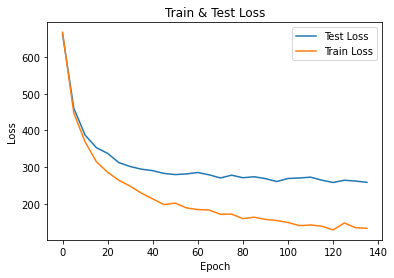

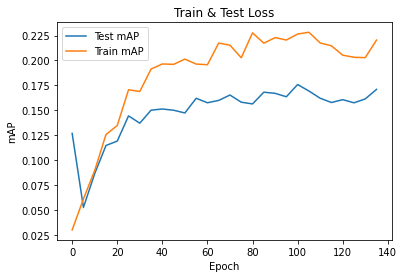

In [16]:
# Training and Test Loss Curve
# Import train & test loss curve
test_losses = torch.load(os.path.join(model_dir, 'test_loss_array'))
train_losses = torch.load(os.path.join(model_dir, 'train_loss_array'))
test_mAP_array = torch.load(os.path.join(model_dir, 'test_mAP_array'))
train_mAP_array = torch.load(os.path.join(model_dir, 'train_mAP_array'))

test_indices = np.argsort(test_losses[0])
train_indices = np.argsort(train_losses[0])
plt.plot(test_losses[0][test_indices], test_losses[1][test_indices], label='Test Loss')
plt.plot(train_losses[0][train_indices], train_losses[1][train_indices], label='Train Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()
plt.show()

test_indices = np.argsort(test_mAP_array[0])
train_indices = np.argsort(train_mAP_array[0])
plt.plot(test_mAP_array[0][test_indices], test_mAP_array[1][test_indices], label='Test mAP');
plt.plot(train_mAP_array[0][train_indices], train_mAP_array[1][train_indices], label='Train mAP');
# plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Train & Test Loss')
plt.legend()
plt.show()

In [2]:
from importlib import reload
import metrics
reload(metrics)
#  Use loader from before to get the image, labels, and original image
test_set = YoloPascalVocDataset('test', normalize=True, augment=False, duplicates=1) # No duplicates for now, dont augment
batch_size = 64
# Run for only one batch
loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Load the model
model = YOLOv1ResNet()
model.eval()
model.to(device)

# Load the model
model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', 'final')))
all_ellipse_predictions = torch.zeros((len(loader)*batch_size*config.S*config.S*config.B, 8), device=device)
total_gt = torch.zeros(len(utils.load_class_array()), device=device)
start_index = 0
for image, labels, original in tqdm(loader):
    image = image.to(device)
    labels = labels.to(device)
    original = original.to(device)
    image, labels, original = utils.prep_data(image, labels, original);
    predictions = model.forward(image)
    # Get prediction Correct or not
    predictions, gt = metrics.get_ellipse_predictions(labels, predictions, conf_threshold=0.23, iou_threshold=0.4, step=6)
    all_ellipse_predictions[start_index:(start_index+len(predictions))] = predictions
    total_gt += gt
    start_index += len(predictions)
    torch.cuda.empty_cache()
    del image, labels, original, predictions

print('mAP:', metrics.get_mAP(all_ellipse_predictions[:start_index], total_gt))

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


/home/nyuad/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
  0%|          | 0/40 [00:00<?, ?it/s]/home/nyuad/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 40/40 [08:11<00:00, 12.29s/it]

mAP: 0.15897709131240845


## Quantitative Results (Provide ten examples, Calculate map and loss)

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


Prediction


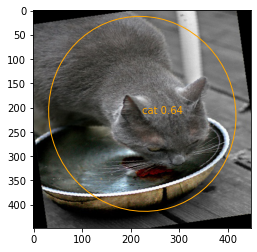

Ground Truth


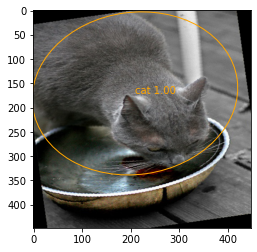

Prediction


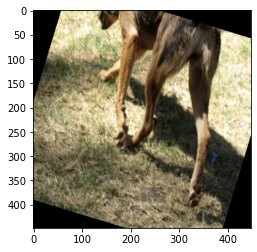

Ground Truth


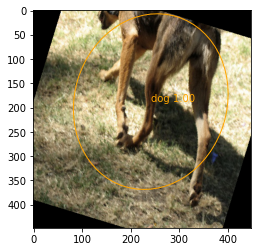

Prediction


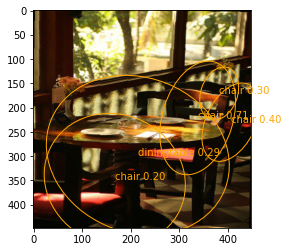

Ground Truth


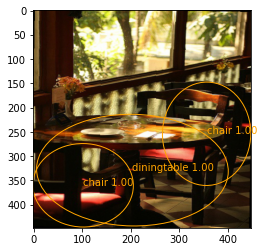

Prediction


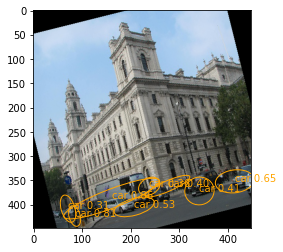

Ground Truth


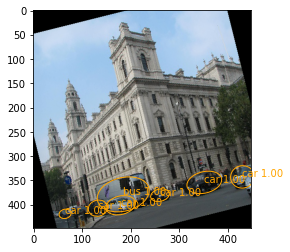

Prediction


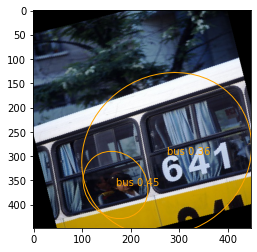

Ground Truth


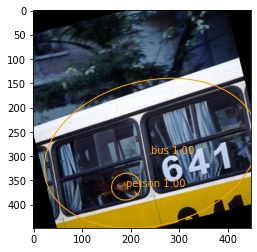

Prediction


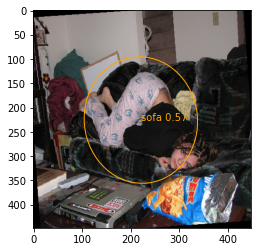

Ground Truth


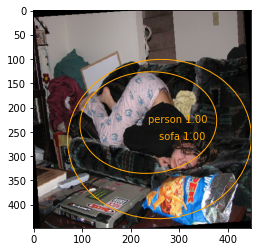

Prediction


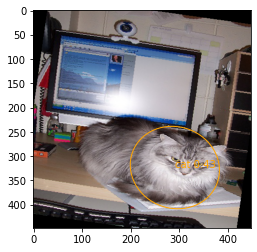

Ground Truth


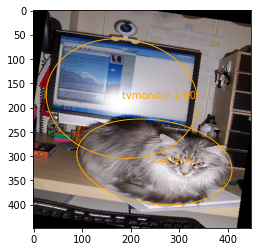

Prediction


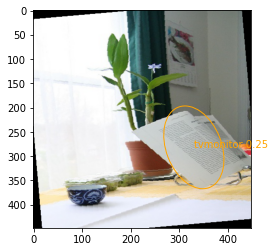

Ground Truth


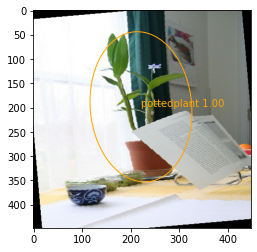

Prediction


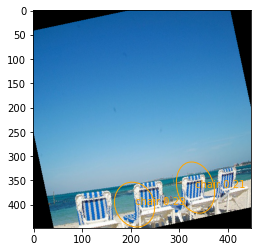

Ground Truth


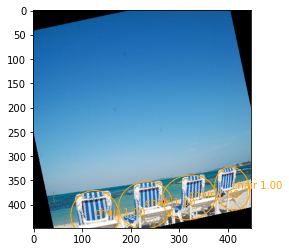

Prediction


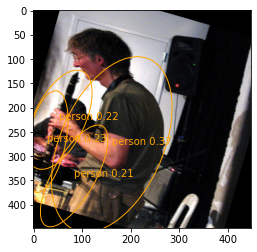

Ground Truth


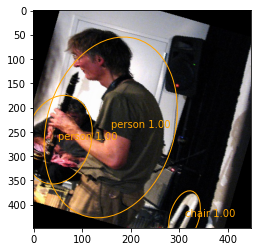

Loss: 0.8870750069618225
mAP: 0.1445021629333496


In [5]:
from importlib import reload
import metrics
reload(metrics)

# Use loader from before to get the image, labels, and original image
test_set = YoloPascalVocDataset('test', normalize=True, augment=False, duplicates=1, angle_range=35) # No duplicates for now, dont augment
# Run for only one batch
loader = DataLoader(test_set, batch_size=10, shuffle=True)

# Load the model
model = YOLOv1ResNet()
model.eval()
model.to(device)

# Load the model
model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', 'final')))

# Get the image, labels, and original image
image, labels, original = next(iter(loader))
image = image.to(device)
labels = labels.to(device)
original = original.to(device)

# Get the predictions
image, labels, original = utils.prep_data(image, labels, original)
predictions = model.forward(image)
classes = utils.load_class_array()

# Plot the ellipses
for i in range(len(image)):
    print("Prediction")
    metrics.plot_ellipses(
        original[i],
        predictions[i],
        classes,
        file=None,
        min_confidence=0.2,
        max_overlap=0.3,
        plot=True
    )
    print("Ground Truth")
    metrics.plot_ellipses(
        original[i],
        labels[i],
        classes,
        file=None,
        min_confidence=0.2,
        max_overlap=0.3,
        plot=True
    )


# Get the loss
loss = SumSquaredErrorLoss()
loss_value = loss(predictions, labels)
print(f'Loss: {loss_value}')

# Get prediction Correct or not
predictions, total_gt = metrics.get_ellipse_predictions(labels, predictions, conf_threshold=0.2, iou_threshold=0.4, nms_threshold=0.5) # iou=0.4 because its elliptical
mAP = metrics.get_mAP(predictions, total_gt)
print(f'mAP: {mAP}')

del model, image, labels, original, predictions, loader, test_set

## Visualization Results on Non-rotated Images  (Provide five examples and visualize )

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


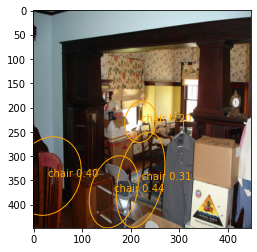

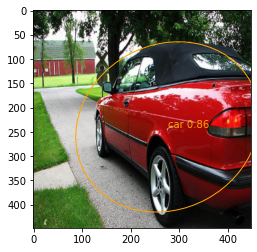

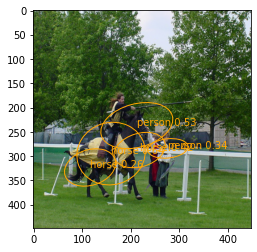

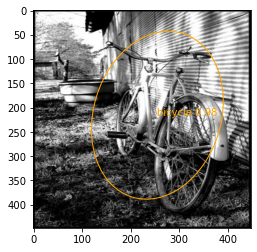

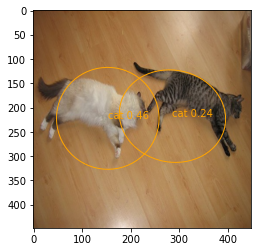

In [3]:
test_set = YoloPascalVocDataset('test', normalize=True, augment=False, duplicates=1, angle_range=0) # No duplicates for now, dont augment, dont rotate
loader = DataLoader(test_set, batch_size=5, shuffle=False)
# Load the model
model = YOLOv1ResNet()
model.eval()
model.to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', 'final')))

# Get the image, labels, and original image
image, labels, original = next(iter(loader))
image = image.to(device)
labels = labels.to(device)

# Get the predictions
image, labels, original = utils.prep_data(image, labels, original)
predictions = model.forward(image)
classes = utils.load_class_array()

# Plot the ellipses
for i in range(len(image)):
    metrics.plot_ellipses(
        original[i],
        predictions[i],
        classes,
        file=None,
        min_confidence=0.2,
        max_overlap=0.3,
        plot=True
    )

del model, image, labels, original, predictions, loader, test_set

## Visualization Results on Rotated Images  (Provide five examples and visualize )

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


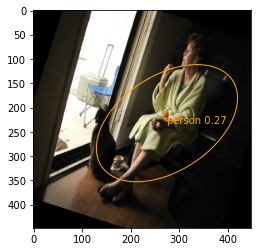

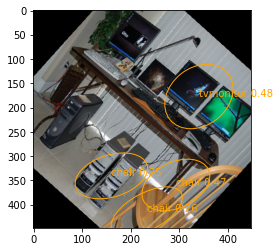

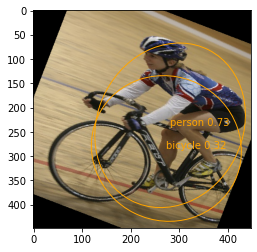

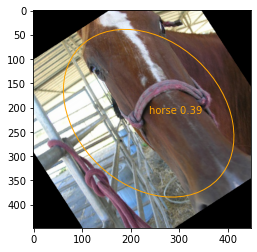

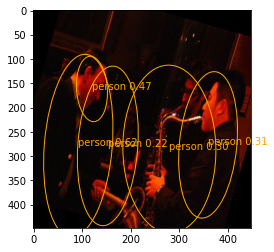

In [ ]:
import metrics
reload(metrics)
test_set = YoloPascalVocDataset('test', normalize=True, augment=False, duplicates=1) # No duplicates for now, dont augment, dont rotate
loader = DataLoader(test_set, batch_size=5, shuffle=True)
# Load the model
model = YOLOv1ResNet()
model.eval()
model.to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'weights', 'final')))

# Get the image, labels, and original image
image, labels, original = next(iter(loader))
image = image.to(device)
labels = labels.to(device)

# Get the predictions
image, labels, original = utils.prep_data(image, labels, original)
predictions = model.forward(image)

# Plot the ellipses
for i in range(len(image)):
    metrics.plot_ellipses(
        original[i],
        predictions[i],
        classes,
        file=None,
        min_confidence=0.2,
        max_overlap=0.3,
        plot=True
    )

del model, image, labels, original, predictions, loader, test_set